In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
df = pd.read_csv('CAISO_zone_1_2019_TimeFeatures.csv')
df.head()

,Date,Load_power,Wind_power,Solar_power,DHI,DNI,GHI,Dew point,Solar zenith angle,Wind speed,...,VISIB,PRCP,Fog,Rain/Drizzle,Snow/Ice Pellets,Thunder,Month_sin,Month_cos,Weekday_sin,Weekday_cos
0,2019-01-01,0.882168,0.130403,0.196968,21.291667,340.708333,154.326389,-11.489111,106.302090,3.535083,...,10.0,0.0,0,0,0,0,0.5,0.866025,0.781831,0.623490
1,2019-01-02,0.995249,0.032074,0.186415,21.395833,329.437500,150.902778,-10.074097,106.243986,1.981389,...,10.0,0.0,0,0,0,0,0.5,0.866025,0.974928,-0.222521
2,2019-01-03,0.998937,0.008031,0.182440,20.527778,337.704861,153.965278,-7.851944,106.180778,1.217292,...,10.0,0.0,0,0,0,0,0.5,0.866025,0.433884,-0.900969
3,2019-01-04,0.979336,0.011052,0.183704,22.479167,325.395833,153.239583,-5.089583,106.112639,1.485556,...,10.0,0.0,0,0,0,0,0.5,0.866025,-0.433884,-0.900969
4,2019-01-05,0.938859,0.044042,0.030214,37.701389,2.423611,38.743056,4.377500,106.036319,2.219514,...,10.0,0.0,0,0,0,0,0.5,0.866025,-0.974928,-0.222521


In [11]:
# Define Features and Target Variable
x = df.drop(columns=['Load_power', 'Date'])
y = df['Load_power']

In [12]:
# Split Data into Training and Testing Sets
x_train, x_test, y_train, y_test, date_train, date_test = train_test_split(
    x, y, df['Date'], test_size=0.2, random_state=42
)
print("\nTraining/Test Split Completed:")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


Training/Test Split Completed:
x_train shape: (292, 22), x_test shape: (73, 22)


In [13]:
# Compute VIF (Variance Inflation Factor)
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

vif_results = calculate_vif(x_train)
print("\nVIF Calculation Completed:")
print(vif_results)


VIF Calculation Completed:
               Feature          VIF
0           Wind_power    39.623460
1          Solar_power   834.833356
2                  DHI   157.204978
3                  DNI   874.788692
4                  GHI   422.788935
5            Dew point    39.722589
6   Solar zenith angle   661.692349
7           Wind speed   161.653828
8    Relative humidity   233.565718
9          Temperature   220.209485
10                 SLP  7144.477581
11                 STP  5528.468770
12               VISIB   162.683924
13                PRCP     1.382442
14                 Fog     1.079102
15        Rain/Drizzle     2.686887
16    Snow/Ice Pellets     1.173213
17             Thunder     2.051920
18           Month_sin     4.125361
19           Month_cos    17.796385
20         Weekday_sin     1.054894
21         Weekday_cos     1.047878


In [14]:
# Use StandardScaler for target (instead of MinMaxScaler)
scaler_x = MinMaxScaler()  # Features
scaler_y = StandardScaler()  # Target

# Fit and transform on training data
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [15]:
# ========== Linear Regression ==========

# Train Linear Regression on Scaled Data
lr = LinearRegression()
lr.fit(x_train_scaled, y_train_scaled)  # Training on scaled y

# Predict on Scaled Features
y_train_predict_lr_scaled = lr.predict(x_train_scaled).reshape(-1, 1)
y_test_predict_lr_scaled = lr.predict(x_test_scaled).reshape(-1, 1)

In [16]:
# Restore Predictions to Original Scale
y_train_predict_lr = scaler_y.inverse_transform(y_train_predict_lr_scaled).flatten()
y_test_predict_lr = scaler_y.inverse_transform(y_test_predict_lr_scaled).flatten()

# Combine Training and Testing Data
y_actual_all = np.concatenate([y_train, y_test])
y_all_predict_lr = np.concatenate([y_train_predict_lr, y_test_predict_lr])

In [17]:
# Function to Evaluate Model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2

# Compute and Print Evaluation Results
train_mse_lr, train_mae_lr, train_mape_lr, train_r2_lr = evaluate_model(y_train, y_train_predict_lr)
test_mse_lr, test_mae_lr, test_mape_lr, test_r2_lr = evaluate_model(y_test, y_test_predict_lr)
all_mse_lr, all_mae_lr, all_mape_lr, all_r2_lr = evaluate_model(y_actual_all, y_all_predict_lr)

print("\nLinear Regression Model Evaluation (Restored Scale - Fixed):")
print(f"Training Set: MSE: {train_mse_lr:.6f}, MAE: {train_mae_lr:.6f}, MAPE: {train_mape_lr:.2f}%, R²: {train_r2_lr:.6f}")
print(f"Test Set: MSE: {test_mse_lr:.6f}, MAE: {test_mae_lr:.6f}, MAPE: {test_mape_lr:.2f}%, R²: {test_r2_lr:.6f}")
print(f"Total Data: MSE: {all_mse_lr:.6f}, MAE: {all_mae_lr:.6f}, MAPE: {all_mape_lr:.2f}%, R²: {all_r2_lr:.6f}")


Linear Regression Model Evaluation (Restored Scale - Fixed):
Training Set: MSE: 0.004235, MAE: 0.052737, MAPE: 5.44%, R²: 0.775160
Test Set: MSE: 0.005977, MAE: 0.058524, MAPE: 5.86%, R²: 0.690538
Total Data: MSE: 0.004583, MAE: 0.053895, MAPE: 5.52%, R²: 0.757985


In [18]:
# ========== Ridge Regression ==========

# Train Ridge Regression with Cross-Validation
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(x_train_scaled, y_train)
print(f"\nBest Alpha for Ridge Regression: {ridge_cv.alpha_}")


Best Alpha for Ridge Regression: 1.0


In [19]:
# Train Ridge Model on Scaled Data
ridge_model = RidgeCV(alphas=[ridge_cv.alpha_])
ridge_model.fit(x_train_scaled, y_train_scaled)  # Use the scaled target during training

# Predict on Scaled Features
y_train_predict_ridge_scaled = ridge_model.predict(x_train_scaled).reshape(-1, 1)
y_test_predict_ridge_scaled = ridge_model.predict(x_test_scaled).reshape(-1, 1)

# Restore Predictions to Original Scale
y_train_predict_ridge = scaler_y.inverse_transform(y_train_predict_ridge_scaled).flatten()
y_test_predict_ridge = scaler_y.inverse_transform(y_test_predict_ridge_scaled).flatten()

# Combine Training and Testing Data for Final Output
y_all_predict_ridge = np.concatenate([y_train_predict_ridge, y_test_predict_ridge])
y_actual_all = np.concatenate([y_train, y_test])

# Function to Evaluate Model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2

# Compute and Print Ridge Regression Evaluation Results (Restored Scale)
train_mse_ridge, train_mae_ridge, train_mape_ridge, train_r2_ridge = evaluate_model(y_train, y_train_predict_ridge)
test_mse_ridge, test_mae_ridge, test_mape_ridge, test_r2_ridge = evaluate_model(y_test, y_test_predict_ridge)
all_mse_ridge, all_mae_ridge, all_mape_ridge, all_r2_ridge = evaluate_model(y_actual_all, y_all_predict_ridge)

print("\nRidge Regression Model Evaluation (Restored Scale):")
print(f"Training Set: MSE: {train_mse_ridge:.6f}, MAE: {train_mae_ridge:.6f}, MAPE: {train_mape_ridge:.2f}%, R²: {train_r2_ridge:.6f}")
print(f"Test Set: MSE: {test_mse_ridge:.6f}, MAE: {test_mae_ridge:.6f}, MAPE: {test_mape_ridge:.2f}%, R²: {test_r2_ridge:.6f}")
print(f"Total Data: MSE: {all_mse_ridge:.6f}, MAE: {all_mae_ridge:.6f}, MAPE: {all_mape_ridge:.2f}%, R²: {all_r2_ridge:.6f}")


Ridge Regression Model Evaluation (Restored Scale):
Training Set: MSE: 0.004413, MAE: 0.054115, MAPE: 5.55%, R²: 0.765688
Test Set: MSE: 0.005283, MAE: 0.055607, MAPE: 5.53%, R²: 0.726473
Total Data: MSE: 0.004587, MAE: 0.054414, MAPE: 5.55%, R²: 0.757779


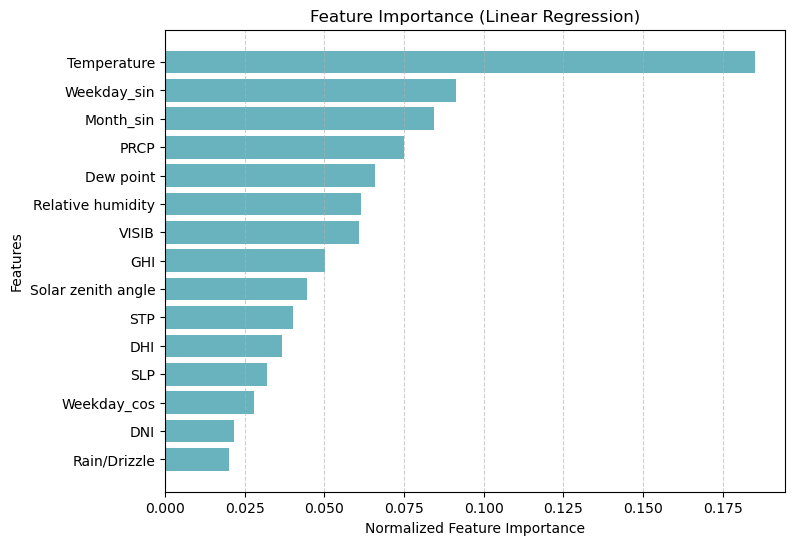

Chart has been saved to: E:/Desktop/Feature_Importance_LR.png

Top 15 Feature Importance (Normalized, Sorted - Ridge Regression):
Temperature: 0.1852
Weekday_sin: 0.0912
Month_sin: 0.0845
PRCP: 0.0750
Dew point: 0.0658
Relative humidity: 0.0616
VISIB: 0.0610
GHI: 0.0502
Solar zenith angle: 0.0447
STP: 0.0401
DHI: 0.0368
SLP: 0.0322
Weekday_cos: 0.0281
DNI: 0.0215
Rain/Drizzle: 0.0201


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute Ridge Feature Importance
feature_importance_ridge = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': np.abs(ridge_model.coef_)
})

# Normalize feature importance (L1 normalization so that sum = 1)
feature_importance_ridge["Normalized Importance"] = (
    feature_importance_ridge["Importance"] / feature_importance_ridge["Importance"].sum()
)

# Sort by normalized importance in descending order
feature_importance_ridge = feature_importance_ridge.sort_values(by="Normalized Importance", ascending=False)

# Select only the top 15 most important features
top_15_features = feature_importance_ridge.head(15)

# Plot Ridge Feature Importance (Normalized)
plt.figure(figsize=(8, 6))
plt.barh(top_15_features["Feature"], top_15_features["Normalized Importance"], color='#69b3be')
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Linear Regression)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Ensure the most important feature is on top

# Save the plot
output_file_path = "E:/Desktop/Feature_Importance_LR.png"
plt.savefig(output_file_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Chart has been saved to: {output_file_path}")

# Print only the top 15 features with normalized importance
print("\nTop 15 Feature Importance (Normalized, Sorted - Ridge Regression):")
for _, row in top_15_features.iterrows():
    print(f"{row['Feature']}: {row['Normalized Importance']:.4f}")


In [21]:
# Save Final Prediction Results (Restored Scale)
predictions_df = pd.DataFrame({
    "Date": np.concatenate([date_train, date_test]), 
    "Actual": y_actual_all,
    "Predicted_Ridge": y_all_predict_ridge,
    "Predicted_LR": y_all_predict_lr
})

# Sort by Date to maintain time-series structure
predictions_df = predictions_df.sort_values(by="Date")

# Define output path
output_pred_file = "E:/Desktop/Regression_Predictions.csv"

# Save to CSV
predictions_df.to_csv(output_pred_file, index=False)

print(f"\nFinal Predictions (Restored Scale) saved to: {output_pred_file}")



Final Predictions (Restored Scale) saved to: E:/Desktop/Regression_Predictions.csv


In [22]:
df = pd.read_csv('E:/Desktop/Regression_Predictions.csv')
df.head()

,Date,Actual,Predicted_Ridge,Predicted_LR
0,2019-01-01,0.882168,0.863750,0.829839
1,2019-01-02,0.995249,0.896804,0.870219
2,2019-01-03,0.998937,0.892703,0.858236
3,2019-01-04,0.979336,0.867143,0.840423
4,2019-01-05,0.938859,0.826132,0.854882


数据预览：
        Date    Actual  Predicted_Ridge  Predicted_LR
0 2019-01-01  0.882168         0.863750      0.829839
1 2019-01-02  0.995249         0.896804      0.870219
2 2019-01-03  0.998937         0.892703      0.858236
3 2019-01-04  0.979336         0.867143      0.840423
4 2019-01-05  0.938859         0.826132      0.854882
Time Series plot saved at: E:/Desktop/Actual_vs_Predicted_Over_Time_LR.png


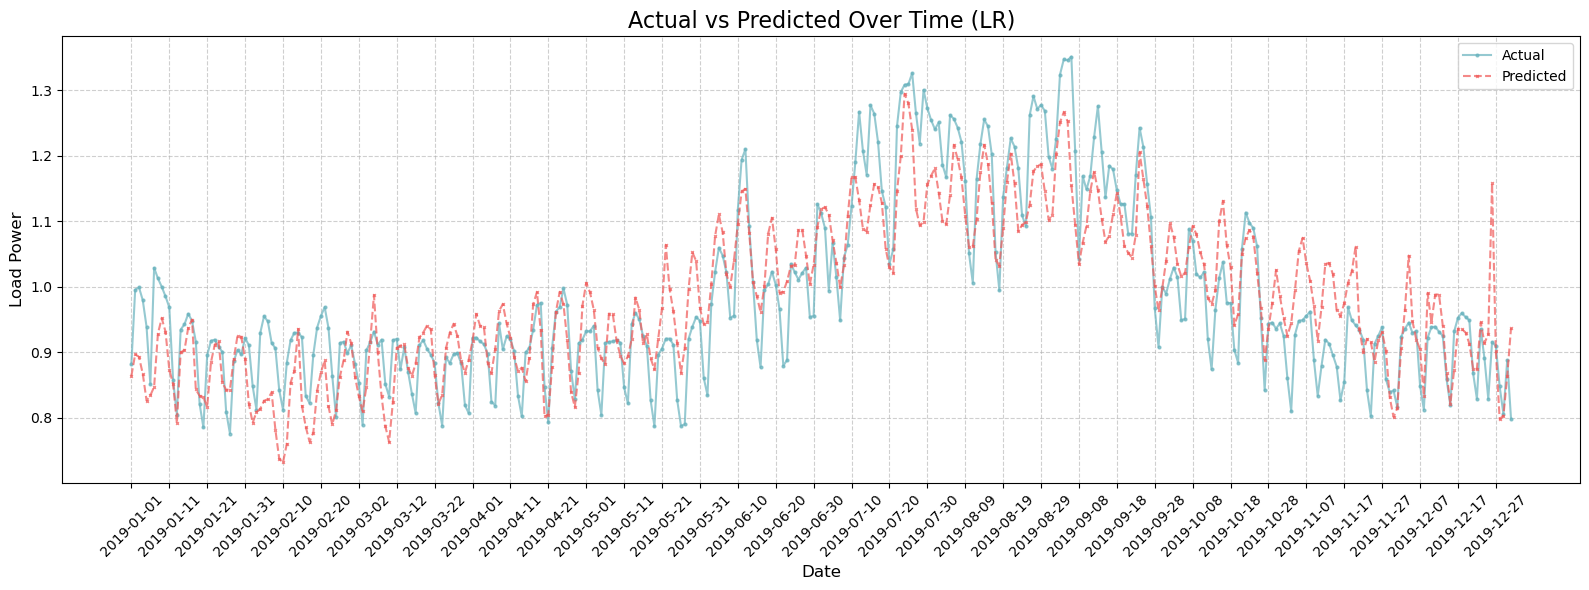

Scatter plot saved at: E:/Desktop/Scatter_Plot_Actual_vs_Predicted_LR.png


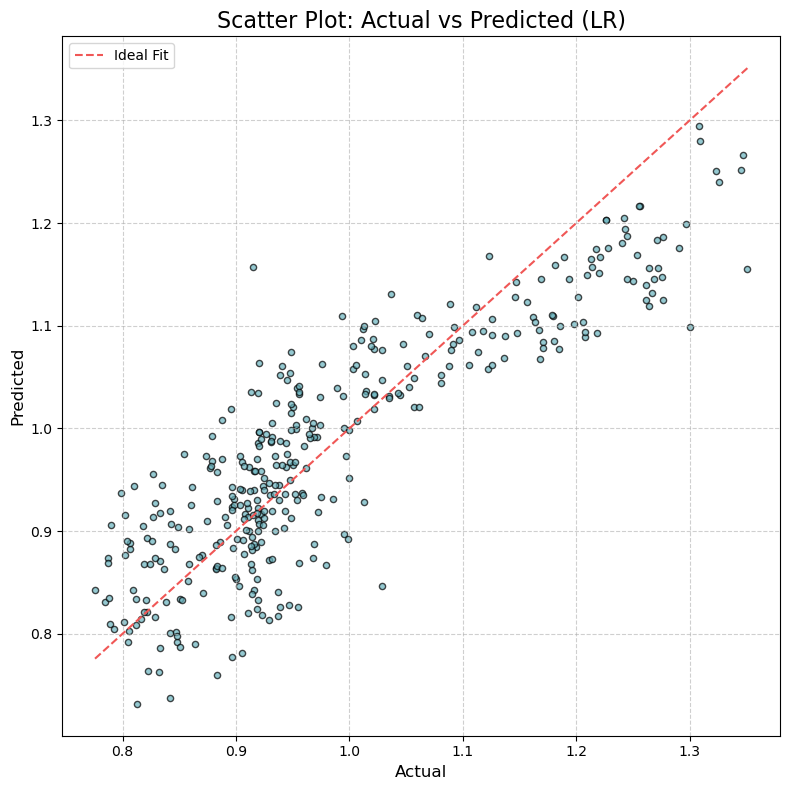

Residual plot saved at: E:/Desktop/Residual_Plot_Over_Time_LR.png


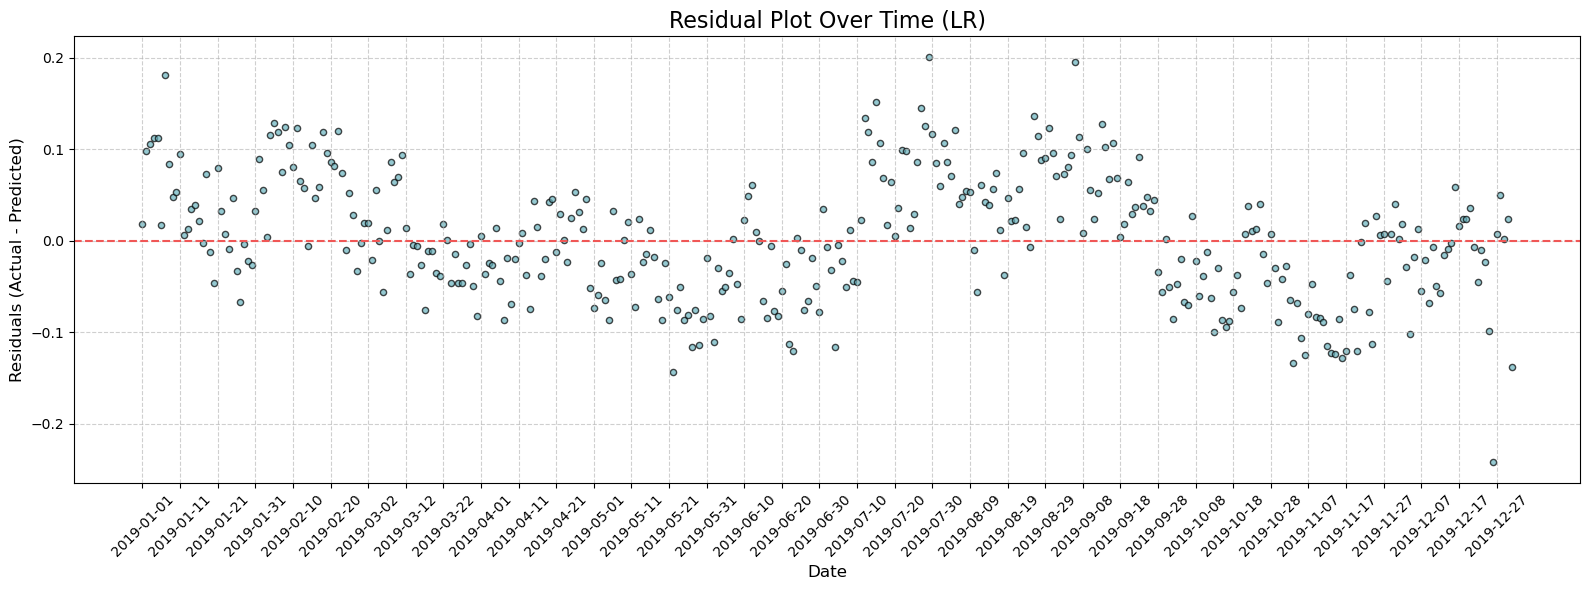

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "E:/Desktop/Regression_Predictions.csv"

results = pd.read_csv(file_path)

if 'Date' in results.columns:
    results['Date'] = pd.to_datetime(results['Date'])

print("数据预览：")
print(results.head())

plt.figure(figsize=(16, 6))
plt.plot(results["Date"].values, results["Actual"].values, label="Actual", linestyle='-', marker='o', markersize=2, alpha=0.7,color='#69b3be')
plt.plot(results["Date"].values, results["Predicted_Ridge"].values, label="Predicted", linestyle='--', marker='x', markersize=2, alpha=0.7, color='#f05756')

plt.title("Actual vs Predicted Over Time (LR)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Load Power", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(results["Date"][::10], rotation=45)  

plt.tight_layout()

output_file_path_time_series = "E:/Desktop/Actual_vs_Predicted_Over_Time_LR.png"
plt.savefig(output_file_path_time_series, dpi=300, bbox_inches='tight')
print(f"Time Series plot saved at: {output_file_path_time_series}")

plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(results["Actual"], results["Predicted_Ridge"], alpha=0.7, edgecolor='k', s=20,color='#69b3be')
plt.plot(
    [results["Actual"].min(), results["Actual"].max()],
    [results["Actual"].min(), results["Actual"].max()],
    '--', label="Ideal Fit" ,color='#f05756' 
)
plt.title("Scatter Plot: Actual vs Predicted (LR)", fontsize=16)
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

output_file_path_scatter = "E:/Desktop/Scatter_Plot_Actual_vs_Predicted_LR.png"
plt.savefig(output_file_path_scatter, dpi=300, bbox_inches='tight')
print(f"Scatter plot saved at: {output_file_path_scatter}")

plt.show()

plt.figure(figsize=(16, 6))
residuals = results["Actual"] - results["Predicted_Ridge"]
plt.scatter(results["Date"].values, residuals.values, alpha=0.7, edgecolor='k', s=20,color='#69b3be')
plt.axhline(y=0, color='#f05756', linestyle='--')  
plt.title("Residual Plot Over Time (LR)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(results["Date"][::10], rotation=45) 

plt.tight_layout()

output_file_path_residual = "E:/Desktop/Residual_Plot_Over_Time_LR.png"
plt.savefig(output_file_path_residual, dpi=300, bbox_inches='tight')
print(f"Residual plot saved at: {output_file_path_residual}")

plt.show()
